In [44]:
import pathlib
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['figure.figsize'] = [12, 8]

import yaml

from utilities import *

import utilities as u


import itertools

In [2]:
from pixell import enmap, utils as putils

In [3]:
values_file = 'configurations/configILC_plotting_validation_check.yaml' 
with open(values_file, 'r') as stream:
            data = yaml.safe_load(stream)

In [4]:


plots_directory = data['plotsdirectory']

analysis_directory = data['analysisdirectory']

savingdirectory = data['savingdirectory']

Nsims = data['Nsims']

results_directory = data['resultsdirectory']
spectra_path = data['spectra_path']
sims_directory = data['sims_directory']
WR = u.write_read(sims_directory)

PP = pathlib.Path(analysis_directory)
Pplots = pathlib.Path(plots_directory)

fgnamefiles = data['fgnamefiles']

estimators_dictionary = data['estimators']
estimators = list(estimators_dictionary.keys())


lista_lmaxes = []

names = {}

for e in estimators:
    elemento = estimators_dictionary[e]
    names[e] = elemento['direc_name']
    lmax_min, lmax_max = elemento['lmax_min'], elemento['lmax_max']
    num = elemento['number']
    lista_lmaxes += [np.linspace(lmax_min, lmax_max, num, dtype = int)]

lmaxes_configs = list(itertools.product(*lista_lmaxes))


#CHOOSE nu
nu = estimators_dictionary[estimators[0]]['nu']

In [5]:
C = u.Converting()

In [6]:
lmax_fixed = 3500

In [7]:
changemap = lambda x: enmap.enmap(x, wcs)
mapsObjA = u.mapNamesObj(nu)
LoadA = u.LoadfftedMaps(mapsObj = mapsObjA, WR = WR, ConvertingObj = C, changemap = changemap, getfft = u.fft, lmax = lmax_fixed)

In [8]:
shape = LoadA.read_shape()
lonCenter, latCenter = 0, 0
shape, wcs = enmap.geometry(shape = shape, res = 1.*putils.arcmin, pos = (lonCenter, latCenter))
modlmap = enmap.modlmap(shape, wcs)
field_names_A = ['ilc', 'ilcdepr']

In [9]:
lmin_A, lmax_A = 30, 3500
Lmin, Lmax = 10, 6000

In [10]:
Binner = u.Binner(shape, wcs, lmin = 10, lmax = 6000, deltal = 30, log = False, nBins = 20)

In [11]:
lmaxes_configs[0]

(3000, 3000, 2000, 2000, 2500, 2500, 2500, 2500)

In [12]:
symlens.get_mc_expressions('hdv', 'TT', ['A', 'B'])

(uC_T_T_l1*(Lx*l1x + Ly*l1y) + uC_T_T_l2*(Lx*l2x + Ly*l2y),
 uC_T_T_l1*(Lx*l1x + Ly*l1y)/(tC_A_T_A_T_l1*tC_B_T_B_T_l2),
 uC_T_T_l2*(Lx*l2x + Ly*l2y)/(tC_A_T_A_T_l2*tC_B_T_B_T_l1))

In [13]:
colors_ests = {}
labels_ests = {}
for e in estimators:
    colors_ests[e] = estimators_dictionary[e]['color']
    labels_ests[e] = estimators_dictionary[e]['label']
    
colors_ests['kk'] = 'black'
colors_ests['kg'] = 'yellow'

labels_ests['kk'] = 'Signal'
labels_ests['kg'] = 'Cross signal'

P = pathlib.Path('output_ILC_1503')/'b4500sybh4500p4500sy3500/'

getoutname = lambda key: f'{key}_{nu}.npy'

ells = np.load(P/getoutname('ells'))
kk = np.load(P/getoutname('kk'))
kg = np.load(P/getoutname('kg'))
gg = np.load(P/getoutname('gg'))

In [15]:
field_names = ['ilc', 'ilcdepr']
f_phi, F_phi, Fr_phi = get_mc_expressions('shear', 'TT', field_names)

In [16]:
F_phi

duC_T_T_l1*uC_T_T_l1*(-1 + 2*(Lx*l1x + Ly*l1y)**2/(L**2*l1**2))/(2*tC_ilc_T_ilc_T_l1**2)

In [17]:
f_phi, F_phi, Fr_phi = get_mc_expressions('shear-hdv', 'TT', field_names)
F_phi

duC_T_T_l1*uC_T_T_l1*(-1 + 2*(Lx*l1x + Ly*l1y)**2/(L**2*l1**2))/(2*tC_ilc_T_ilc_T_l1**2)

In [18]:
Fr_phi

duC_T_T_l2*uC_T_T_l2*(-1 + 2*(Lx*l2x + Ly*l2y)**2/(L**2*l2**2))/(2*tC_ilc_T_ilc_T_l2**2)

In [30]:

class EstimatorM(object):
    def __init__(self, shape, wcs, feed_dict, estimator,
                 lmin, lmax,
                 field_names = None, groups = None, 
                 Lmin = 20, Lmax = 6000, 
                 hardening = None, estimator_to_harden = 'hu_ok', XY = 'TT', direc = 'presavedcalcs/'):

        self.directory = pathlib.Path(direc)
        self.lmax = lmax
        self.lmin = lmin

        if hardening == '':
            hardening = None        

        xmask, ymask, kmask = self.get_masks(shape, wcs, xlmin = lmin, xlmax = lmax, xlx = None, xly = None,
                                             ylmin = lmin, ylmax = lmax, ylx = None, yly = None,
                                             Lmin = Lmin, Lmax = Lmax, Lx = None, Ly = None)

        self.fdict = feed_dict
           
        f, F, Fr = self.get_mc_expressions(estimator, XY = 'TT', field_names = field_names, estimator_to_harden = estimator_to_harden,
                           hardening = hardening, feed_dict = feed_dict, shape = shape, wcs = wcs, xmask = xmask, ymask = ymask, kmask = kmask)

       
        self.Al = self.A_l_custom(shape, wcs, feed_dict, f, F, 
                          xmask = xmask, ymask = ymask, groups = None, kmask = kmask)
        
        self.F = F
        self.f = f
        self.Fr = Fr

        self.xmask = xmask
        self.ymask = ymask
        self.kmask = kmask
        self.shape, self.wcs = shape, wcs

        self.field_names = field_names

        self.estimator = estimator

        self.XY = XY

        self.name = self.estimator+self.field_names[0]+'-'+self.field_names[1]

    def get_masks(self, shape, wcs, xlmin, xlmax, xlx, xly,
                                    ylmin, ylmax, ylx, yly,
                                    Lmin, Lmax, Lx, Ly):
        xmask = self.get_mask(shape, wcs, xlmin, xlmax, xlx, xly)
        ymask = self.get_mask(shape, wcs, ylmin, ylmax, ylx, yly)
        kmask = self.get_mask(shape, wcs, Lmin, Lmax, Lx, Ly)
        return xmask, ymask, kmask

    def get_mask(self, shape, wcs, lmin, lmax, lx, ly):
        return symlens.mask_kspace(shape, wcs, lxcut = lx, lycut = ly, lmin = lmin, lmax = lmax)

    def A_l_custom(self, shape, wcs, feed_dict, f, F, xmask, ymask, 
                   groups = None,kmask = None):
        return symlens.A_l_custom(shape, wcs, feed_dict, f, F, 
                                  xmask = xmask, ymask = ymask, groups = None,kmask = kmask) 
    
    def reconstruct_other(self, map1, map2, field_names = None, estimator = None, F = None):
        feed_dict = self.fdict.copy()
         
        if field_names is None:
            field_names = self.field_names
            
        name1 = field_names[0]
        name2 = field_names[1]

        feed_dict[name1] = map1
        feed_dict[name2] = map2

        xname1, xname2 = name1+'_l1', name2+'_l2'
        groups = self._get_groups(self.estimator if estimator is None else estimator, noise = False)
        return self._reconstruct(feed_dict, xname = xname1, yname = xname2, F = F)
    
    
    def reconstruct(self, map1, map2):
        mappa = self.reconstruct_other(map1, map2)
        return mappa
        


    def _reconstruct(self,feed_dict,xname ='X_l1',yname = 'Y_l2', groups = None, physical_units = True, F = None):
        uqe = symlens.unnormalized_quadratic_estimator_custom(self.shape,self.wcs,feed_dict,
                                                      self.F if F is None else F,xname = xname,yname = yname,
                                                      xmask = self.xmask,ymask = self.ymask,
                                                      groups = groups,physical_units = physical_units)
        return self.Al * uqe * self.kmask

    def get_Nl_cross(self, Estimator2, tipo = 't'):
        name = f'N_l_cross_{self.name}_{Estimator2.name}'
        
        try:
            if self.estimator == Estimator2.estimator:
                N_l_cross_i_j = self.read(self.estimator, name)
            else:
                N_l_cross_i_j = self.read_from_double_dir(self.directory, self.lmax, self.lmin, Estimator2.lmax, Estimator2.lmin, self.estimator, Estimator2.estimator, name)#note one could also add case where they are swapped
            print('Read noise from file')
        except:
            feed_dict = {**self.fdict, **Estimator2.fdict}        
            N_l_cross_i_j = self.get_Nl_cross_other(feed_dict, Estimator2, tipo = tipo)
            if self.estimator == Estimator2.estimator:
                self.save(self.estimator, name, N_l_cross_i_j)
            else:
                self.save_to_double_dir(self.directory, self.lmax, self.lmin, Estimator2.lmax, Estimator2.lmin, self.estimator, Estimator2.estimator, name, N_l_cross_i_j) 
        return N_l_cross_i_j
    
    
    def get_Nl_cross_other(self, feed_dict, Estimator2, tipo = 't'):
        
        N_l_cross_i_j = self.N_l_cross_custom(self.shape, self.wcs, feed_dict, self.XY, Estimator2.XY, self.F, Estimator2.F, Estimator2.Fr,
                                                    xmask = self.xmask*Estimator2.xmask, ymask = self.ymask*Estimator2.ymask,
                                                    field_names_alpha = self.field_names, field_names_beta = Estimator2.field_names,
                                                    falpha = None, fbeta = None, Aalpha = self.Al, Abeta = Estimator2.Al,
                                                    groups = None, kmask = self.kmask*Estimator2.kmask,
                                                    power_name = tipo)

        return N_l_cross_i_j


    def N_l_cross_custom(self, shape, wcs, feed_dict, alpha_XY, beta_XY, Falpha, Fbeta, Fbeta_rev,
                        xmask = None, ymask = None,
                        field_names_alpha = None, field_names_beta = None,
                        falpha = None, fbeta = None, Aalpha = None, Abeta = None,
                        groups = None, kmask = None, power_name = "t"):

        return symlens.N_l_cross_custom(shape, wcs, feed_dict, alpha_XY, beta_XY, Falpha, Fbeta, Fbeta_rev,
                        xmask = xmask, ymask = ymask,
                        field_names_alpha = field_names_alpha, field_names_beta = field_names_beta,
                        falpha = falpha, fbeta = fbeta, Aalpha = Aalpha, Abeta = Abeta,
                        groups = groups, kmask = kmask, power_name = power_name)
    

    def _get_groups(self, Estimator1, Estimator2 = None, noise = True):
        if Estimator2 is None:
            Estimator2 = Estimator1
        return qe._get_groups(Estimator1, Estimator2, noise = noise)
    
    def get_mc_expressions(self, estimator, XY = 'TT', field_names = None, estimator_to_harden = 'hu_ok', 
                           hardening = None, feed_dict = None, shape = None, wcs = None, xmask = None, ymask = None, kmask= None):
        
        f1, f2 = field_names if field_names is not None else (None,None)
        
        def t1(ab):
            a,b = ab
            return symlens.e(qe.cross_names(a,b,f1,f1)+"_l1")
        def t2(ab):
            a,b = ab
            return symlens.e(qe.cross_names(a,b,f2,f2)+"_l2")

        X,Y = XY
        if hardening is not None:
            f_phi, F_phi, Fr_phi = self.get_mc_expressions(estimator_to_harden, field_names = field_names, 
            feed_dict = feed_dict, shape = shape, wcs = wcs, xmask = xmask, ymask = ymask, kmask = kmask)
            f_bias, F_bias, _ = self.get_mc_expressions(hardening, field_names = field_names)
            f_bh, F_bh, Fr_bh = self.get_mc_expressions(f'{hardening}-hardened', estimator_to_harden = estimator_to_harden, field_names = field_names, feed_dict = feed_dict, shape = shape, wcs = wcs, xmask = xmask, ymask = ymask, kmask = kmask)
            # 1 / Response of the biasing agent to the biasing agent
            try:
                self.fdict[f'A{hardening}_{hardening}_L'] = self.read(hardening, f'A{hardening}_{hardening}_L')
            except:
                self.fdict[f'A{hardening}_{hardening}_L'] = self.A_l_custom(shape, wcs, feed_dict, f_bias, F_bias,
                                                        xmask = xmask, ymask = ymask, groups = None, kmask = kmask)
                self.save(hardening, f'A{hardening}_{hardening}_L', self.fdict[f'A{hardening}_{hardening}_L'])

            try:
                self.fdict[f'Aphi_{hardening}_L'] = self.read(hardening, f'Aphi_{hardening}_L')
            except:
                # 1 / Response of the biasing agent to CMB lensing
                self.fdict[f'Aphi_{hardening}_L'] = self.A_l_custom(shape, wcs, feed_dict, f_bias, F_phi, #f_bias, F_phi
                                                        xmask = xmask, ymask = ymask, groups = None, kmask = kmask)
                self.save(hardening, f'Aphi_{hardening}_L', self.fdict[f'Aphi_{hardening}_L'])

            #self.fdict[f'Aphi_phi_L'] = self.A_l_custom(shape, wcs, feed_dict, f_phi, F_phi,
            #                                            xmask = xmask, ymask = ymask, groups = None, kmask = kmask)
            #self.fdict[f'A{hardening}_phi_L'] = self.A_l_custom(shape, wcs, feed_dict, f_phi, F_bias,
            #                                            xmask = xmask, ymask = ymask, groups = None, kmask = kmask)
            f, F, Fr = f_bh, F_bh, Fr_bh
        
        elif 'hardened' in estimator:
            hardening, hardened_name = estimator.split('-')
            assert XY=="TT", "BH only implemented for TT."
            f_phi, F_phi, F_phi_r = self.get_mc_expressions(estimator_to_harden, XY, field_names = field_names, feed_dict = feed_dict, shape = shape, wcs = wcs, xmask = xmask, ymask = ymask, kmask = kmask)
            f_src, F_src, F_src_r = self.get_mc_expressions(hardening, XY, field_names = field_names)
            A_src_src = symlens.e(f'A{hardening}_{hardening}_L')
            A_phi_src = symlens.e(f'Aphi_{hardening}_L')
            
            #f = f_phi - A_src_src / A_phi_src * f_src
            #F = f / t1(XY) / t2(XY) / 2
            
            F = F_phi - A_src_src / A_phi_src * F_src
            Fr = F_phi_r - A_src_src / A_phi_src * F_src_r
            f = f_phi
            fr = f
            
        elif 'src' in estimator:
            f = symlens.e(f'pc{estimator}_T_T_l1')*symlens.e(f'pc{estimator}_T_T_l2')
            F = f / symlens.e(qe.cross_names(X,X,f1,f1)+"_l1") / symlens.e(qe.cross_names(X,X,f1,f1)+"_l2") / 2 #ASSUME FIRST LEG X IS ILC OR 148, i.e. non deproject map
            fr = f
            Fr = f / symlens.e(qe.cross_names(X,X,f1,f1)+"_l1") / symlens.e(qe.cross_names(X,X,f1,f1)+"_l2") / 2 
            #F = f / t1(XY) / t2(XY) / 2
            #F = f / (t1(X+X)*t2(Y+Y)+tcross1(XY)*tcross2(XY))
            #Fr = f / (t2(X+X)*t1(Y+Y)+t12(XY)*t12(XY))
        elif estimator == 'symm' or estimator == 'symm-sh':
            
            if estimator == 'symm':
                symmetrised = 'hdv'
            elif estimator == 'symm-sh':
                symmetrised = 'shear-hdv'
                        

            f_phiA, F_phiA, Fr_phiA = self.get_mc_expressions(symmetrised, field_names = field_names)
            
            field_names_r = field_names.copy()
            field_names_r.reverse()
            
            self.field_names_r = field_names_r
            
            f_phiB, F_phiB, Fr_phiB = self.get_mc_expressions(symmetrised, field_names = field_names_r)
            
            
            self.f_phiA, self.F_phiA, self.Fr_phiA = f_phiA, F_phiA, Fr_phiA
            self.f_phiB, self.F_phiB, self.Fr_phiB = f_phiB, F_phiB, Fr_phiB
            
            try:
                AA = self.read(estimator, f'AA_{symmetrised}')
            except: 
                AA = self.A_l_custom(shape, wcs, feed_dict, f_phiA, F_phiA,
                                                        xmask = xmask, ymask = ymask, groups = None, kmask = kmask)
                self.save(estimator, f'AA_{symmetrised}', AA)
 
            try:
                AB = self.read(estimator, f'AB_{symmetrised}')
            except:
                AB = self.A_l_custom(shape, wcs, feed_dict, f_phiB, F_phiB,
                                                        xmask = xmask, ymask = ymask, groups = None, kmask = kmask)
                self.save(estimator, f'AB_{symmetrised}', AB)

            try:
                NA = self.read(estimator, f'NA_{symmetrised}')
            except:
                NA = self.N_l_cross_custom(shape, wcs, feed_dict, XY, XY, F_phiA, F_phiA, Fr_phiA,
                                     xmask = xmask, ymask = ymask, field_names_alpha = field_names, field_names_beta = field_names,
                                     falpha = f_phiA, fbeta = f_phiA,
                                     Aalpha = AA, Abeta = AA, groups = None, kmask = kmask)
                self.save(estimator, f'NA_{symmetrised}', NA)

            try:
                NB = self.read(estimator, f'NB_{symmetrised}')
            except:
                NB = self.N_l_cross_custom(shape, wcs, feed_dict, XY, XY, F_phiB, F_phiB, Fr_phiB,
                                     xmask = xmask, ymask = ymask, field_names_alpha = field_names_r, field_names_beta = field_names_r,
                                     falpha = f_phiB, fbeta = f_phiB,
                                     Aalpha = AB, Abeta = AB, groups = None, kmask = kmask)
                self.save(estimator, f'NB_{symmetrised}', NB)
             
            try:
                NAB = self.read(estimator, f'NAB_{symmetrised}')
                print('Read NAB for symm from file')
            except:
                NAB = self.N_l_cross_custom(shape, wcs, feed_dict, XY, XY, F_phiA, F_phiB, Fr_phiB,
                                     xmask = xmask, ymask = ymask, field_names_alpha = field_names, field_names_beta = field_names_r,
                                     falpha = f_phiA, fbeta = f_phiB,
                                     Aalpha = AA, Abeta = AB, groups = None, kmask = kmask)
                self.save(estimator, f'NAB_{symmetrised}', NAB)

            wA, wB = getasymmweights(NA, NB, NAB)
            
            self.Ncoadd = getcoaddednoise(NA, NB, NAB)
            
            f = f_phiA
            
            F = symlens.e('wA')*F_phiA+symlens.e('wB')*F_phiB
            Fr = symlens.e('wA')*Fr_phiA+symlens.e('wB')*Fr_phiB
            
            #F = symlens.e('wA')*F_phiA+symlens.e('wB')*Fr_phiA
            #Fr = symlens.e('wA')*Fr_phiA+symlens.e('wB')*F_phiA
            
            self.fdict['wA'] = wA*AA   #NOTE HERE DEFINITION OF WEIGHT
            self.fdict['wB'] = wB*AB
            
        else:
            f_phi, F_phi, Fr_phi = symlens.get_mc_expressions(estimator, XY, field_names, estimator_to_harden)
            f, F, Fr = f_phi, F_phi, Fr_phi

        
        return f, F, Fr

    def save_to_double_dir(self, directory, lmaxA, lminA, lmaxB, lminB, estimatorA, estimatorB, name, quantity):
        direc = directory/f'{estimatorA}_{estimatorB}_{lmaxA}_{lminA}_{lmaxB}_{lminB}'
        if not direc.exists():
            direc.mkdir(parents = True, exist_ok = True)
        np.save(direc/f'{name}', quantity)
    
    def save_to_dir(self, directory, lmax, lmin, estimator, name, quantity):
        direc = directory/f'{estimator}_{lmax}_{lmin}'
        if not direc.exists():
            direc.mkdir(parents = True, exist_ok = True)
        np.save(direc/f'{name}', quantity)    
    
    def save(self, estimator, name, quantity):
        self.save_to_dir(self.directory, self.lmax, self.lmin, estimator, name, quantity)

    def read_from_double_dir(self, directory, lmaxA, lminA, lmaxB, lminB, estimatorA, estimatorB, name):
        return np.load(directory/f'{estimatorA}_{estimatorB}_{lmaxA}_{lminA}_{lmaxB}_{lminB}'/f'{name}.npy')

    def read_from_dir(self, directory, lmax, lmin, estimator, name):
        return np.load(directory/f'{estimator}_{lmax}_{lmin}'/f'{name}.npy')
    
    def read(self, estimator, name, verbose = True):
        result = self.read_from_dir(self.directory, self.lmax, self.lmin, estimator, name)
        if verbose:
            print('Read saved')
        return result

In [31]:
estimators = list(estimators_dictionary.keys())
estimators = ['shear-hdv', 'shear']#['symm', 'symmbh']#, 'symmbh']#, 'symm']

In [47]:
Binner = u.Binner(shape, wcs, lmin = 10, lmax = 6000, deltal = 30, log = False, nBins = 20)

In [48]:
noise_dict = {}

estimator = 'shear-hdv'

#estimator = 'hdv'

hardening_A, hardening_B = None, None
tszprofile_A, tszprofile_B = None, None
estimator_to_harden_A, estimator_to_harden_B = None, None

field_names_A = ['ilc', 'ilcdepr']
feed_dict = u.Loadfeed_dict(pathlib.Path(spectra_path), field_names_A, field_names_A, modlmap, 
                                hardening_A, hardening_B, tszprofile_A, tszprofile_B)
A = EstimatorM(shape, wcs, feed_dict, estimator, lmin_A, lmax_A,
                                    field_names = field_names_A, groups = None, Lmin = Lmin, Lmax = Lmax,
                                    hardening = hardening_A, estimator_to_harden = estimator_to_harden_A, XY = 'TT')
    
NAB_cross = A.get_Nl_cross_other(feed_dict, A)
el, NAB_cross_binned = Binner.bin_spectra(NAB_cross)
noise_dict['shear-hdv-AB'] = NAB_cross_binned

field_names_A = ['ilcdepr', 'ilc']
B = EstimatorM(shape, wcs, feed_dict, estimator, lmin_A, lmax_A,
                                    field_names = field_names_A, groups = None, Lmin = Lmin, Lmax = Lmax,
                                    hardening = hardening_A, estimator_to_harden = estimator_to_harden_A, XY = 'TT')
    
NAB_cross = B.get_Nl_cross_other(feed_dict, B)
el, NAB_cross_binned = Binner.bin_spectra(NAB_cross)
noise_dict['shear-hdv-BA'] = NAB_cross_binned


NAB_cross = A.get_Nl_cross_other(feed_dict, B)
el, NAB_cross_binned = Binner.bin_spectra(NAB_cross)
noise_dict['shear-hdv-AB-BA'] = NAB_cross_binned

NAB_cross = B.get_Nl_cross_other(feed_dict, A)
el, NAB_cross_binned = Binner.bin_spectra(NAB_cross)
noise_dict['shear-hdv-BA-AB'] = NAB_cross_binned



field_names_A = ['ilcA', 'ilcB']
feed_dict = u.Loadfeed_dict(pathlib.Path(spectra_path), field_names_A, field_names_A, modlmap, 
                                hardening_A, hardening_B, tszprofile_A, tszprofile_B)
C = EstimatorM(shape, wcs, feed_dict, 'shear', lmin_A, lmax_A,
                                    field_names = field_names_A, groups = None, Lmin = Lmin, Lmax = Lmax,
                                    hardening = hardening_A, estimator_to_harden = estimator_to_harden_A, XY = 'TT')

NAB_cross = C.get_Nl_cross_other(feed_dict, C)
el, NAB_cross_binned = Binner.bin_spectra(NAB_cross)
noise_dict['shear'] = NAB_cross_binned

In [49]:
A.F

duC_T_T_l1*uC_T_T_l1*(-1 + 2*(Lx*l1x + Ly*l1y)**2/(L**2*l1**2))/(2*tC_ilc_T_ilc_T_l1**2)

In [50]:
A.Fr

duC_T_T_l2*uC_T_T_l2*(-1 + 2*(Lx*l2x + Ly*l2y)**2/(L**2*l2**2))/(2*tC_ilc_T_ilc_T_l2**2)

In [51]:
B.F

duC_T_T_l1*uC_T_T_l1*(-1 + 2*(Lx*l1x + Ly*l1y)**2/(L**2*l1**2))/(2*tC_ilcdepr_T_ilcdepr_T_l1**2)

In [52]:
C.Fr

duC_T_T_l2*uC_T_T_l2*(-1 + 2*(Lx*l2x + Ly*l2y)**2/(L**2*l2**2))/(2*tC_ilcB_T_ilcB_T_l2**2)

In [53]:
field_names_A = ['ilc', 'ilcdepr']
feed_dict = u.Loadfeed_dict(pathlib.Path(spectra_path), field_names_A, field_names_A, modlmap, 
                                hardening_A, hardening_B, tszprofile_A, tszprofile_B)
D = EstimatorM(shape, wcs, feed_dict, 'symm-sh', lmin_A, lmax_A,
                                    field_names = field_names_A, groups = None, Lmin = Lmin, Lmax = Lmax,
                                    hardening = hardening_A, estimator_to_harden = estimator_to_harden_A, XY = 'TT')
    
NAB_cross = D.get_Nl_cross_other(feed_dict, D)
el, NAB_cross_binned = Binner.bin_spectra(NAB_cross)
noise_dict['symm-sh'] = NAB_cross_binned

/gpfs/fs0/scratch/r/rbond/omard/CORI17112020/qelensingcomb/utilities.py:529: RuntimeWarning: invalid value encountered in true_divide
  w_E1_E2 /= w
/gpfs/fs0/scratch/r/rbond/omard/CORI17112020/qelensingcomb/utilities.py:530: RuntimeWarning: invalid value encountered in true_divide
  w_E2_E1 /= w
/gpfs/fs0/scratch/r/rbond/omard/CORI17112020/qelensingcomb/utilities.py:542: RuntimeWarning: invalid value encountered in true_divide
  coadd_noise = (N_E1_E2*N_E2_E1-N_E1_E2_E2_E1**2.)/w


In [54]:
D.F

duC_T_T_l1*uC_T_T_l1*wB*(-1 + 2*(Lx*l1x + Ly*l1y)**2/(L**2*l1**2))/(2*tC_ilcdepr_T_ilcdepr_T_l1**2) + duC_T_T_l1*uC_T_T_l1*wA*(-1 + 2*(Lx*l1x + Ly*l1y)**2/(L**2*l1**2))/(2*tC_ilc_T_ilc_T_l1**2)

In [55]:
nn = getcoaddednoise(noise_dict['shear-hdv-AB'], noise_dict['shear-hdv-BA'], noise_dict['shear-hdv-AB-BA'])

In [56]:
noise_dict.keys()

dict_keys(['shear-hdv-AB', 'shear-hdv-BA', 'shear-hdv-AB-BA', 'shear-hdv-BA-AB', 'shear', 'symm-sh'])

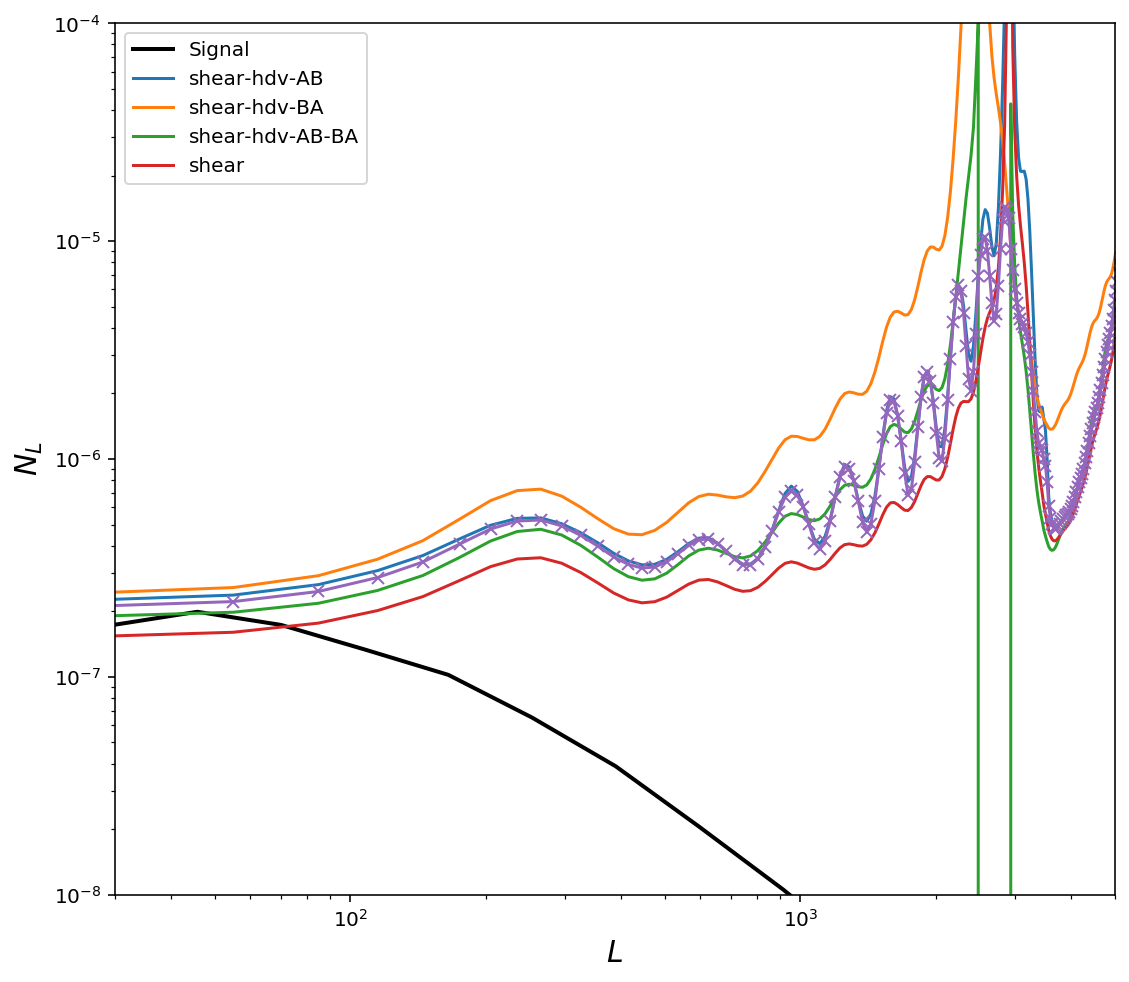

In [60]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, sharex = True, figsize = (8, 7))
ax.plot(ells, kk, color = colors_ests['kk'], lw = 2, label = labels_ests['kk'])

for est in ['shear-hdv-AB', 'shear-hdv-BA', 'shear-hdv-AB-BA', 'shear']:#, 'symm-sh']: 
#for est in noise_dict.keys():
    #marker = 'x' if est == 'shear-hdv-AB-BA' else None
    ax.plot(el, noise_dict[est], label = est, marker = marker)
    
    
ax.plot(el, nn, marker = 'x')
#for e_index, e in enumerate(estimators):
#    ax.plot(ells, noises[e_index, e_index], color = colors_ests[e], label = labels_ests[e])
    
#ax.plot(ee, temp, marker = '+')
    
    
#ax.plot(ee, temp2, marker = 'o')
    
ax.set_ylabel('$N_L$', size = 15)
ax.set_xlabel('$L$', size = 15)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(30, 5000)
ax.set_ylim(1e-8, 1e-4)

ax.legend()

fig.tight_layout()

plt.show()

KeyError: 'shear-hdv'

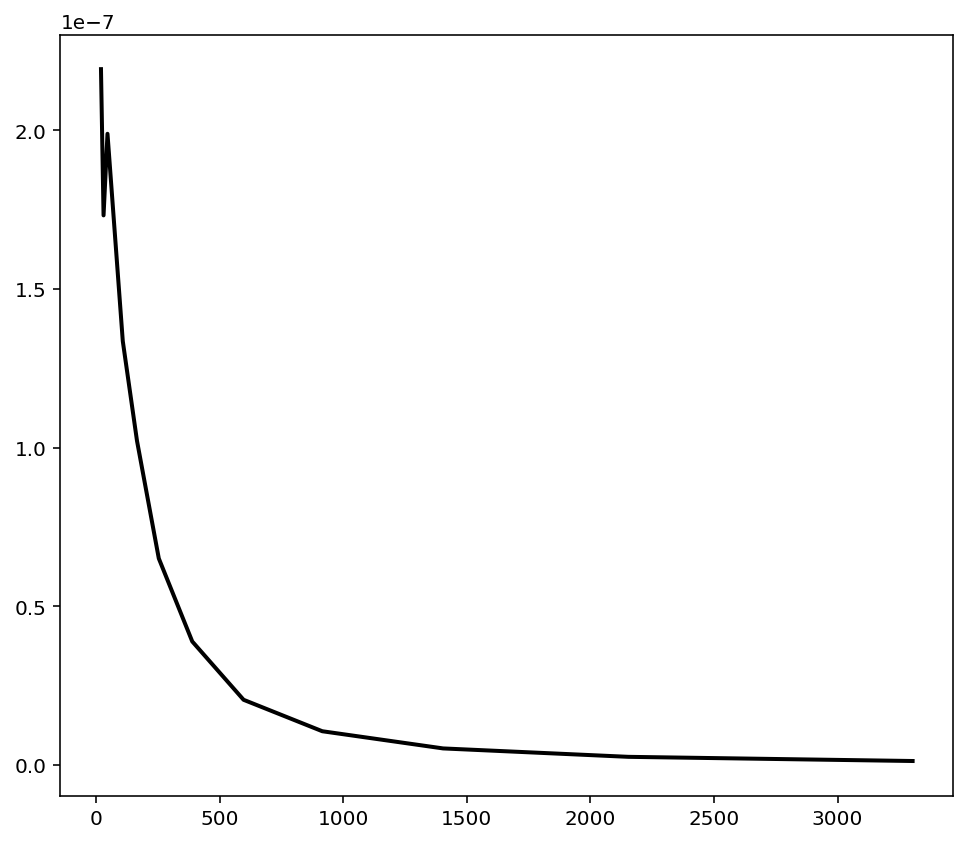

In [188]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, sharex = True, figsize = (8, 7))
ax.plot(ells, kk, color = colors_ests['kk'], lw = 2, label = labels_ests['kk'])

for e_index, est in enumerate(estimators):
    ax.plot(el, noise_dict[est], color = colors_ests[est], label = labels_ests[est])
    
#for e_index, e in enumerate(estimators):
#    ax.plot(ells, noises[e_index, e_index], color = colors_ests[e], label = labels_ests[e])
    
#ax.plot(ee, temp, marker = '+')
    
    
#ax.plot(ee, temp2, marker = 'o')
    
ax.set_ylabel('$N_L$', size = 15)
ax.set_xlabel('$L$', size = 15)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(30, 5000)
ax.set_ylim(1e-8, 1e-4)

ax.legend()

fig.tight_layout()

plt.show()

In [44]:
A.Al

ndmap([[0.00000000e+00 9.46439964e-10 2.39406534e-10 ... 1.08458398e-10
  2.39406534e-10 9.46439964e-10]
 [9.56142564e-10 4.77519221e-10 1.92653636e-10 ... 9.80787973e-11
  1.92653636e-10 4.77519221e-10]
 [2.41833371e-10 1.93819399e-10 1.22159791e-10 ... 7.64532087e-11
  1.22159791e-10 1.93819399e-10]
 ...
 [1.09537566e-10 9.88564424e-11 7.67409969e-11 ... 5.63491843e-11
  7.67409969e-11 9.88564424e-11]
 [2.41833371e-10 1.93819399e-10 1.22159791e-10 ... 7.64532087e-11
  1.22159791e-10 1.93819399e-10]
 [9.56142564e-10 4.77519221e-10 1.92653636e-10 ... 9.80787973e-11
  1.92653636e-10 4.77519221e-10]],car:{cdelt:[0.01667,0.01667],crval:[0,0],crpix:[601,601]})

In [49]:
1/(1-A.fdict['Asrcpbh_srcpbh_L']/(A.fdict['Asrcpbh_phi_L']*A.fdict['Aphi_srcpbh_L']))

/home/r/rbond/omard/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


ndmap([[            nan -5.43563638e-09 -1.36354037e-09 ... -6.06739761e-10
  -1.36354037e-09 -5.43563638e-09]
 [-5.48513921e-09 -2.73468260e-09 -1.09333879e-09 ... -5.46559006e-10
  -1.09333879e-09 -2.73468260e-09]
 [-1.37600496e-09 -1.09931120e-09 -6.85659630e-10 ... -4.21086853e-10
  -6.85659630e-10 -1.09931120e-09]
 ...
 [-6.12329309e-10 -5.50572730e-10 -4.22574540e-10 ... -3.04244692e-10
  -4.22574540e-10 -5.50572730e-10]
 [-1.37600496e-09 -1.09931120e-09 -6.85659630e-10 ... -4.21086853e-10
  -6.85659630e-10 -1.09931120e-09]
 [-5.48513921e-09 -2.73468260e-09 -1.09333879e-09 ... -5.46559006e-10
  -1.09333879e-09 -2.73468260e-09]],car:{cdelt:[0.01667,0.01667],crval:[0,0],crpix:[601,601]})

In [ ]:
feed_dict['pcsrc_T_T'] = 1

In [ ]:
f, F, Fr = A.get_mc_expressions('symmbh', hardening = 'src', estimator_to_harden = 'symm', field_names = field_names_A, wcs = wcs, shape = shape, feed_dict=feed_dict,
                    xmask = A.get_mask(shape, wcs, lmin_A, lmax_A, 0, 0), ymask = A.get_mask(shape, wcs, lmin_A, lmax_A, 0, 0))

In [ ]:
F

In [ ]:
F

In [ ]:
f_phiA, F_phiA, Fr_phiA = A.get_mc_expressions('hdv', field_names = field_names_A)

In [ ]:
fs, Fs, _ = A.get_mc_expressions('src', field_names = field_names_A)

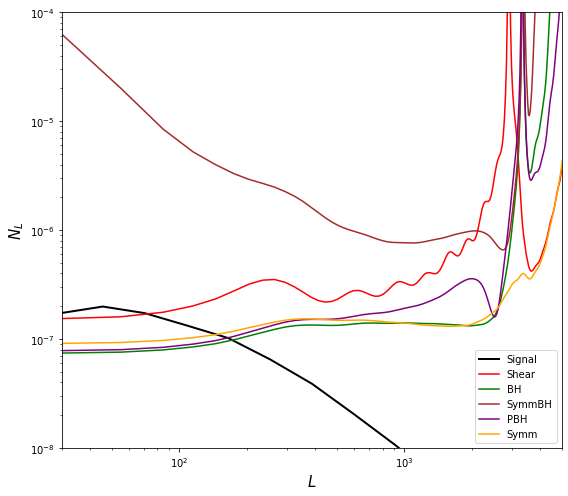

In [15]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, sharex = True, figsize = (8, 7))
ax.plot(ells, kk, color = colors_ests['kk'], lw = 2, label = labels_ests['kk'])

for e_index, e in enumerate(estimators):
    ax.plot(el, noise_dict[e], color = colors_ests[e], label = labels_ests[e])
    
#for e_index, e in enumerate(estimators):
#    ax.plot(ells, noises[e_index, e_index], color = colors_ests[e], label = labels_ests[e])
    
    
    
ax.set_ylabel('$N_L$', size = 15)
ax.set_xlabel('$L$', size = 15)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(30, 5000)
ax.set_ylim(1e-8, 1e-4)

ax.legend()

fig.tight_layout()

plt.show()

In [36]:
p = pathlib.Path('output1102')
pilc = pathlib.Path('output_ILC_1102')

In [40]:
path = p/'h3500s3500b3500'/'tsz/'
pathILC = pilc/'h3500s3500b3500sy3500'/'tsz/'

In [41]:
T = np.load(path/'T_tsz_148.npy')
Tilc = np.load(pathILC/'T_tsz_ilc.npy')
kk = np.load(path/'kk_tsz_148.npy')
ells = np.load(path/'ells_tsz_148.npy')

### What happens if you just do a simple rescaling?

i.e. Q[Tnu0, Tnu0] -> Q[Tnu0, Tnu0]*(nu*nu)/(nu0*nu0)

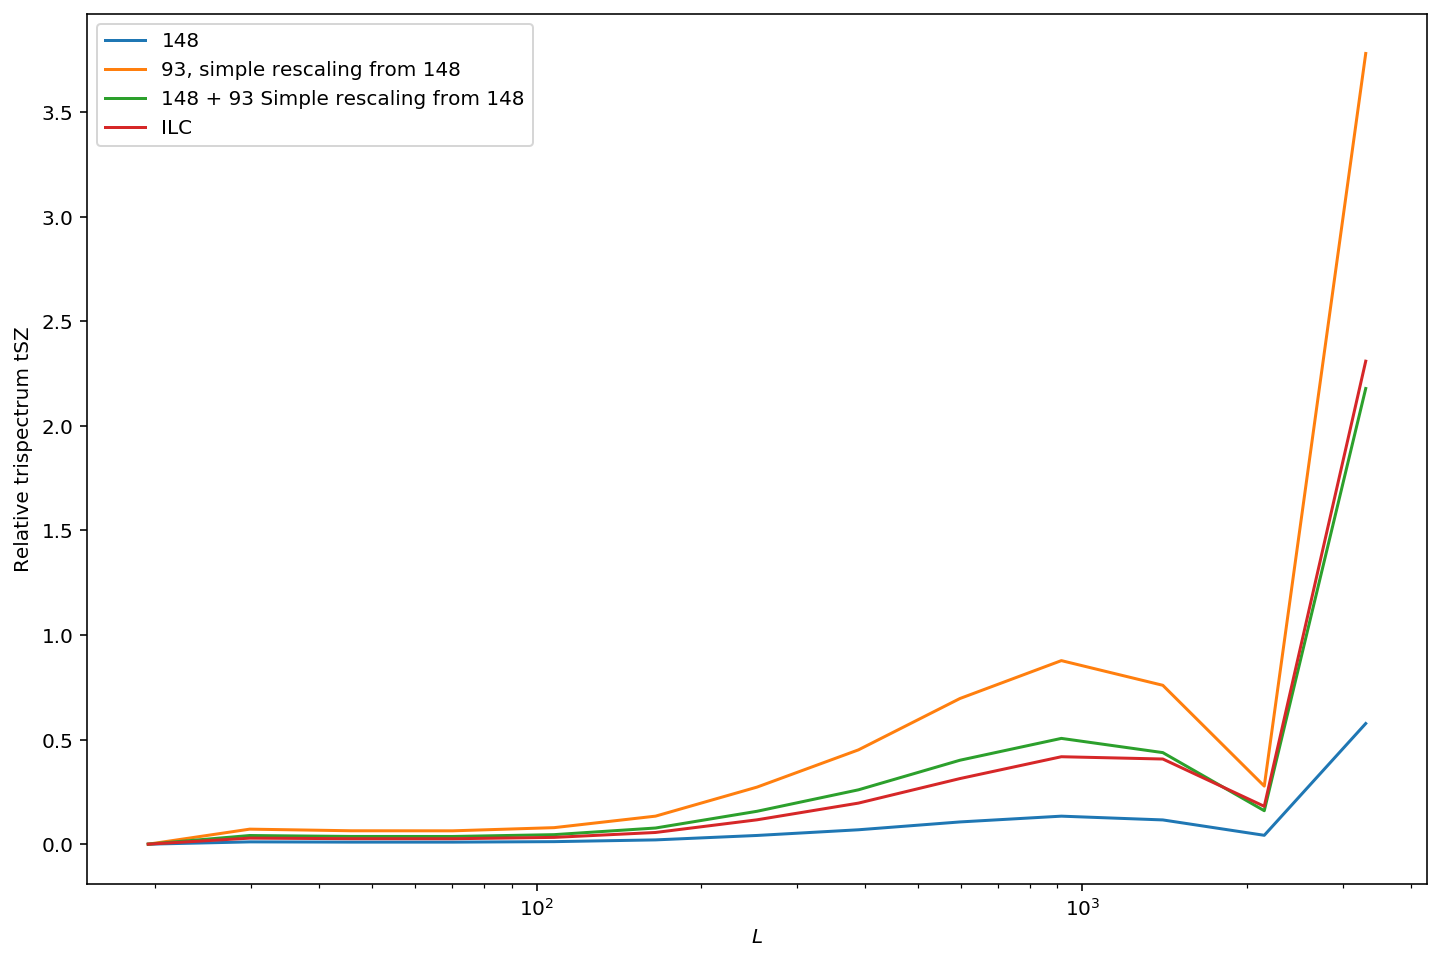

In [44]:
plt.plot(ells, T[0, 0]/kk, label = '148')
plt.plot(ells, T[0, 0]/kk*1.6**4, label = '93, simple rescaling from 148')

plt.plot(ells, 0.5*(T[0, 0]/kk+T[0, 0]/kk*1.6**4), label = '148 + 93 Simple rescaling from 148')

plt.plot(ells, Tilc[0, 0]/kk, label = 'ILC')
plt.xscale('log')
plt.xlabel('$L$')
plt.ylabel('Relative trispectrum tSZ')
plt.legend()

### Try with simple estimator for one single cutout sim

In [110]:
import utilities as u
from pixell import enmap, utils as putils
from scipy.interpolate import interp1d

In [65]:
lmin_A = 30
Lmin, Lmax = 20, 6000

In [66]:
nuA = 148

In [67]:
mapsObjA = u.mapNamesObj(nuA)

In [68]:
hardening_A = None

In [69]:
changemap = lambda x: enmap.enmap(x, wcs)

In [70]:
C = u.Converting()

In [71]:
spectra_path = 'input_spectra/'
sims_directory = '../extract_sehgal/manusmaps/flat_maps_large/newmaps11022021/148/'
WR = u.write_read(sims_directory)

In [72]:
lmax_A = 3500
LoadA = u.LoadfftedMaps(mapsObj = mapsObjA, WR = WR, ConvertingObj = C, changemap = changemap, getfft = u.fft, lmax = lmax_A)

In [73]:
shape = LoadA.read_shape()
lonCenter, latCenter = 0, 0
shape, wcs = enmap.geometry(shape = shape, res = 1.*putils.arcmin, pos = (lonCenter, latCenter))
modlmap = enmap.modlmap(shape, wcs)

In [74]:
field_names_A = ['X', 'Y']

In [75]:
feed_dict = u.Loadfeed_dict(pathlib.Path(spectra_path), field_names_A, field_names_A, modlmap)

In [79]:
field_names_A_ilc = ['ilc', 'ilc']
feed_dict_ilc = u.Loadfeed_dict(pathlib.Path(spectra_path), field_names_A_ilc, field_names_A_ilc, modlmap)

In [85]:
estA = 'hu_ok'

In [90]:
A = u.Estimator(shape, wcs, feed_dict, estA, lmin_A, lmax_A,
                                    field_names = field_names_A, groups = None, Lmin = Lmin, Lmax = Lmax,
                                    hardening = hardening_A, XY = 'TT')


Ailc = u.Estimator(shape, wcs, feed_dict_ilc, estA, lmin_A, lmax_A,
                                    field_names = field_names_A_ilc, groups = None, Lmin = Lmin, Lmax = Lmax,
                                    hardening = hardening_A, XY = 'TT')

In [78]:
i = 0
fgnamefile = 'tsz'
cmb0_fft, cmb1_fft, fg_fft_masked_A1, fg_gaussian_fft_masked_A1, fg_fft_masked_A2, fg_gaussian_fft_masked_A2, kappa_fft_masked, gal_fft_map = LoadA.read_all(fgnamefile, i)

In [91]:
Binner = u.Binner(shape, wcs, lmin = 10, lmax = 4000, deltal = 100, log = True, nBins = 15)

In [96]:
rec_fg_map_A = A.reconstruct(fg_fft_masked_A1, fg_fft_masked_A2)
rec_fg_gauss_map_A = A.reconstruct(fg_gaussian_fft_masked_A1, fg_gaussian_fft_masked_A2)
el, clfg_A_B = Binner.bin_maps(rec_fg_map_A, rec_fg_map_A, pixel_units = True, get_p2d = False)
el, clfg_gauss_A_B = Binner.bin_maps(rec_fg_gauss_map_A, rec_fg_gauss_map_A, pixel_units = True, get_p2d = False)
trispectrum_A_B = clfg_A_B-clfg_gauss_A_B

/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


In [106]:
path = pathlib.Path('/scratch/r/rbond/omard/CORI17112020/extract_sehgal/LensQuEst-1/ilcresults/')
w_ilc = np.loadtxt(path/'w_ilc.txt')
ells, w_ilc_93, w_ilc_145 = w_ilc[:, 0], w_ilc[:, 3], w_ilc[:, 4]

Text(0, 0.5, '$w_{ilc}$')

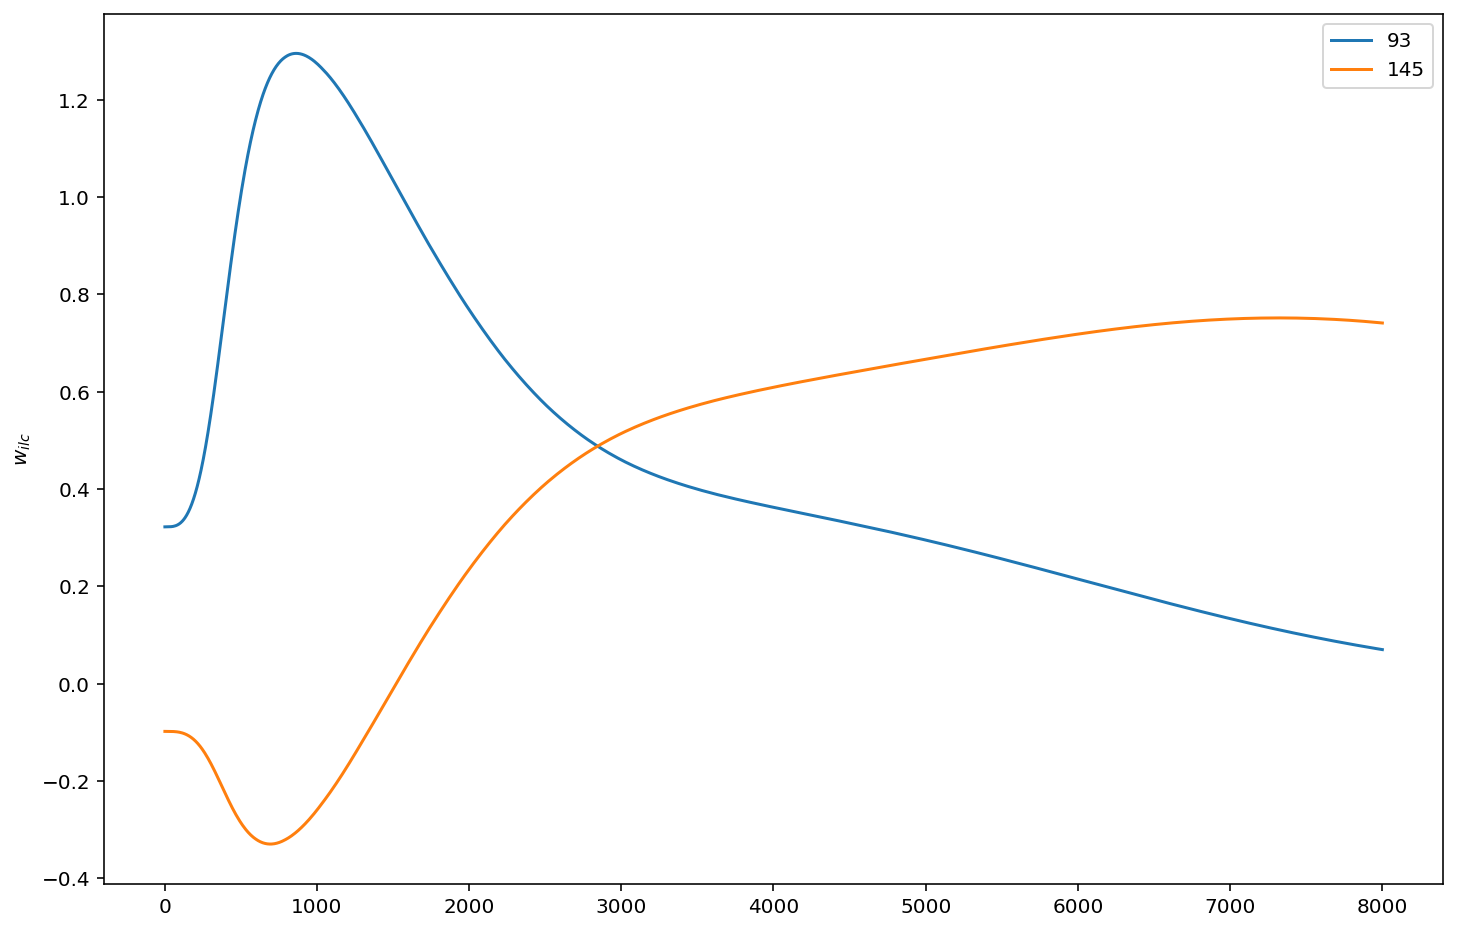

In [108]:
plt.plot(ells, w_ilc_93, label = '93')
plt.plot(ells, w_ilc_145, label = '145')
plt.legend()
plt.ylabel('$w_{ilc}$')

In [115]:
w_ilc = np.loadtxt(path/'w_ilc.txt')
ells, w_ilc_93_145 = w_ilc[:, 0], w_ilc[:, 3:5]

In [117]:
AtSZ = np.array([1, 1.6])
product_ilc_tSZ = np.einsum('...i, i -> ...', w_ilc_93_145, AtSZ)

In [118]:
interpolated_ilc = interp1d(ells, product_ilc_tSZ, kind = 'linear', bounds_error = False, fill_value = 0.)
W_ilc_tSZ_93 = interpolated_ilc(modlmap)

In [120]:
factor = 1.6
rec_fg_map_A = A.reconstruct(fg_fft_masked_A1*W_ilc_tSZ_93, fg_fft_masked_A2*W_ilc_tSZ_93)
rec_fg_gauss_map_A = A.reconstruct(fg_gaussian_fft_masked_A1*W_ilc_tSZ_93, fg_gaussian_fft_masked_A2*W_ilc_tSZ_93)
el, clfg_A_B = Binner.bin_maps(rec_fg_map_A, rec_fg_map_A, pixel_units = True, get_p2d = False)
el, clfg_gauss_A_B = Binner.bin_maps(rec_fg_gauss_map_A, rec_fg_gauss_map_A, pixel_units = True, get_p2d = False)
trispectrum_A_B_93_145_ilc = clfg_A_B-clfg_gauss_A_B

/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


In [97]:
rec_fg_map_A = Ailc.reconstruct(fg_fft_masked_A1, fg_fft_masked_A2)
rec_fg_gauss_map_A = Ailc.reconstruct(fg_gaussian_fft_masked_A1, fg_gaussian_fft_masked_A2)
el, clfg_A_B = Binner.bin_maps(rec_fg_map_A, rec_fg_map_A, pixel_units = True, get_p2d = False)
el, clfg_gauss_A_B = Binner.bin_maps(rec_fg_gauss_map_A, rec_fg_gauss_map_A, pixel_units = True, get_p2d = False)
trispectrum_A_B_ilc = clfg_A_B-clfg_gauss_A_B

/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


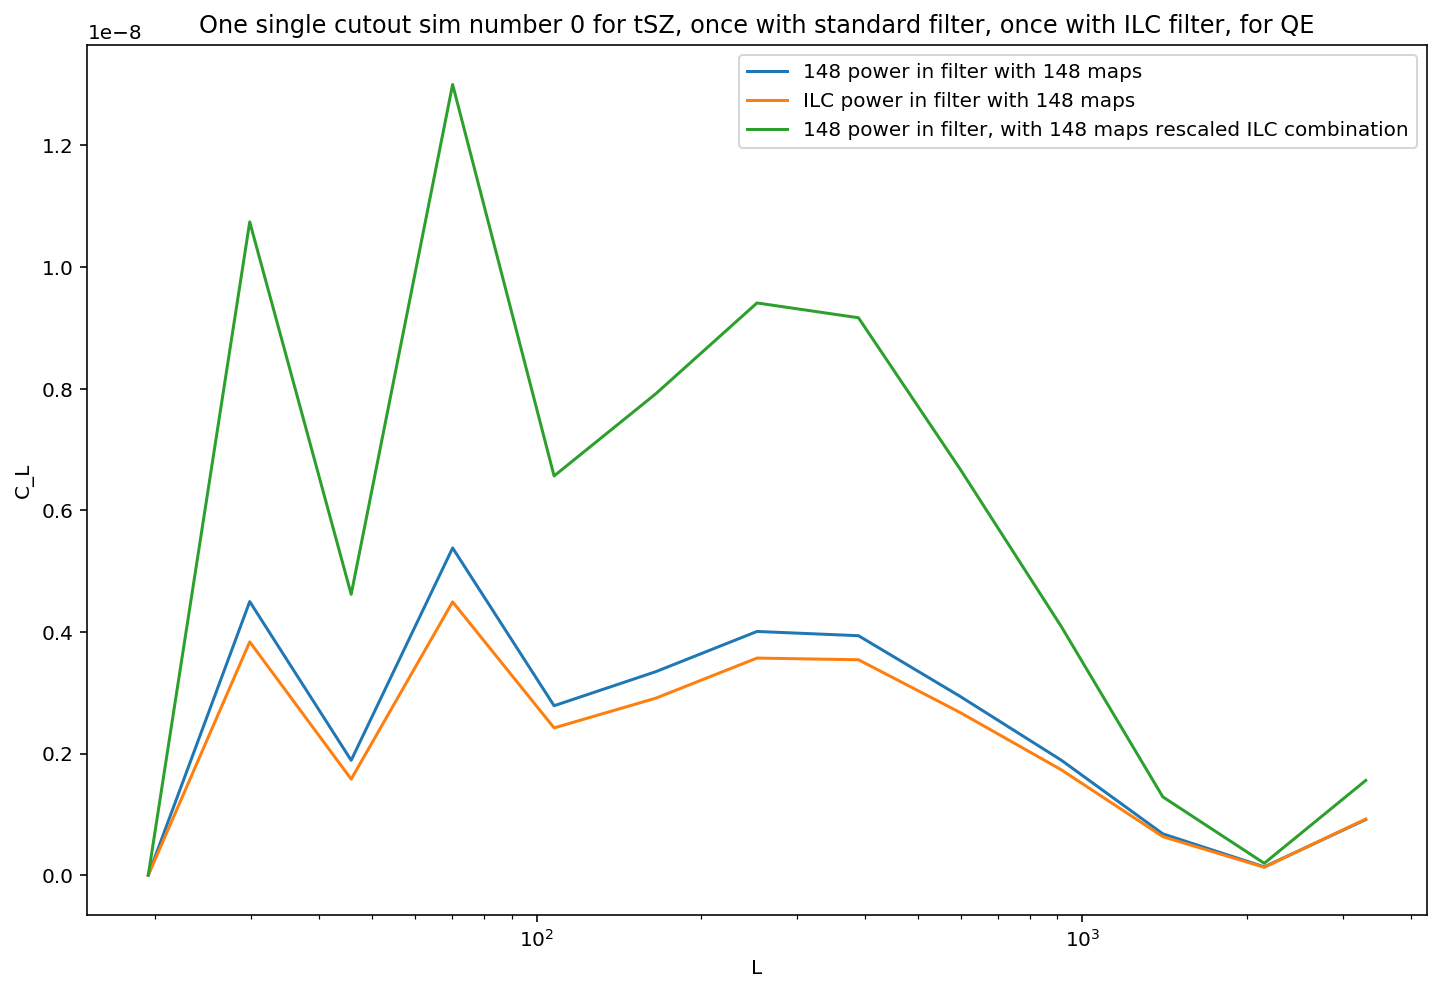

In [124]:
plt.title(f'One single cutout sim number {i} for tSZ, once with standard filter, once with ILC filter, for QE')
plt.plot(el, trispectrum_A_B, label = '148 power in filter with 148 maps')
plt.plot(el, trispectrum_A_B_ilc, label = 'ILC power in filter with 148 maps')
plt.plot(el, trispectrum_A_B_93_145_ilc, label = '148 power in filter, with 148 maps rescaled ILC combination')
plt.xlabel('L')
plt.ylabel('C_L')
plt.xscale('log')
plt.legend()

In [70]:
from orphics import lensing,io,cosmology,maps

import symlens as s

In [74]:
shape,wcs = enmap.geometry(shape=(512,512),res=2.0*putils.arcmin,pos=(0,0))
modlmap = enmap.modlmap(shape,wcs)
theory = cosmology.default_theory()
ells = np.arange(0,3000,1)
ctt = theory.lCl('TT',ells)

feed_dict = {}
feed_dict['uC_T_T'] = s.interp(ells,ctt)(modlmap)
feed_dict['tC_T_T'] = s.interp(ells,ctt)(modlmap)+(33.*np.pi/180./60.)**2./s.gauss_beam(modlmap,7.0)**2.
feed_dict['pc_T_T'] = 1.
tellmin = 10 ; tellmax = 3000
xmask = s.mask_kspace(shape,wcs,lmin=tellmin,lmax=tellmax)

In [75]:
H = s.HardenedTT(shape, wcs, feed_dict, xmask, xmask)

/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/factorize.py:301: RuntimeWarning: overflow encountered in multiply
  val += ot2d*ffft
/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/factorize.py:314: RuntimeWarning: overflow encountered in multiply
  return val * mul
/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/factorize.py:314: RuntimeWarning: overflow encountered in multiply
  return val * mul


In [77]:

f = s.Ldl1 * s.e('uC_T_T_l1') + s.Ldl2 * s.e('uC_T_T_l2')
F = f / 2 / s.e('tC_T_T_l1') / s.e('tC_T_T_l2')
expr1 = f * F
integral = s.integrate(shape,wcs,feed_dict,expr1,xmask=xmask,ymask=xmask).real
Nl = modlmap**4./integral/4.
bin_edges = np.arange(10,3000,40)
binner = s.bin2D(modlmap,bin_edges)
cents,nl1d = binner.bin(Nl)
cents, nl1dh = binner.bin(H.get_Nl())

/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/factorize.py:314: RuntimeWarning: overflow encountered in multiply
  return val * mul


In [79]:
estimator = 'hu_ok'
f_phi, F_phi, _ = s.get_mc_expressions(estimator, estimator_to_harden = 'hu_ok', XY = 'TT')
f_src, F_src, _ = s.get_mc_expressions('src', 'TT')
A_src_src = s.e(f'A{hardening}_{hardening}_L')
A_phi_src = s.e(f'Aphi_{hardening}_L')
f = f_phi - A_src_src / A_phi_src * f_src
F = F_phi - A_src_src / A_phi_src * F_src
fr = f
Fr = F

In [80]:
H.F_bh

(uC_T_T_l1*(Lx*l1x + Ly*l1y) + uC_T_T_l2*(Lx*l2x + Ly*l2y) - Asrc_src_L*pc_T_T_l1*pc_T_T_l2/Aphi_src_L)/(2*tC_T_T_l1*tC_T_T_l2)

In [83]:
s.A_l_custom(shape,wcs,feed_dict,f_phi,F_src,xmask=xmask,ymask=xmask,groups=None)==s.A_l_custom(shape,wcs,feed_dict,f_src,F_phi,xmask=xmask,ymask=xmask,groups=None)

ndmap([[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]],car:{cdelt:[0.03333,0.03333],crval:[0,0],crpix:[257,257]})